# Viral coinfection networks

*Russell Y. Neches, Lee T. Call, A. David Paez Espino, Nikos C. Kyrpides*

Plan :

* Use [species distribution modeling](http://rspatial.org/sdm/) to estimate species ranges for host and phage
    * Geographic overlay for compartmentalized biomes, particularly host-associations?
* Use phylogenomic approach to biogeography to identify phage with interesting recent patterns of movement
* For each host-phage link from the CRISPR data, build a latent space of ecological features :
    * geographic range of host
    * geographic range of phage
    * intersection of host and phage range
    * phage biogeography
    * host biogeography (if we can find more than one strain of the host)
    * phylogenetic diversity of host
    * phylogenetic diversity of phage
    * co-phylogeny graph properties
* Train a model on the latent space
    * Success : Predictive model of new and/or unobserved infection
    * Failure : Explore database limitations, develop recommendations to address them
    
New Plan :

* Build datset for training a graph neural network (GNN) using CRISPR arrays from 
isolates
    * Spacer arrays labels :
        * Host taxonomy (7 hierarchical categories)
        * Host phylogenetic "address"
            * PD to fixed points in the tree? 
                * Anchor species
                * Well-supported deeply branching points
        * Genomic context (distances, counts and model fit scores for all host genes -- sparse matrix of pfams)
    * Viral OTU labels :
        * Viral taxonomy (7 hierarchical categories (?))
        * Viral phylogenetic "address"
            * I'm not sure if this is even possible
        * Genomic context where larger viral fragments are available (genomic distances and model fit scores -- sparse matrix of pfams)
* Train GNN on coinfection networks from isolates
* Predict properties of hosts and viruses from CRISPRs in metagenomes
    * Pull the full metagenomic assembled contig, get the genomic context for the CRISPR
    * Build network of associated vOTUs
    * Given the networks we've seen before, what is the likeliest
        * Host taxonomy
        * Host genomic context
        * Viral taxonomy
        * Viral genomic context
        * Other hosts and viruses missing from the network (ANN-GNN)

## Part 1 : Load data and build networks

* Blast all spacers against all Viral genomes


Table 1 : Spacers/Arrays connected to Viruses
  
| Element | Total No. | Connected to Viruses |
| ------- | --------- | -------------------- |
| Spacers | xxx       | xxx                  |
| Arrays  | xxx       | xxx                  |


Table 2 : Spacers connected to viral genomes from...
  
| Element | Connected to isolate viruses | Connected to prophages | Connected to metagenomic viruses (mVCs) |
| --- | --- | --- | --- |
| Spacers | xxx                          | xxx                    | xxx                                     |
| Arrays  | xxx                          | xxx                    | xxx                                     |

Table 3 : Viruses connected to spacers

* Number of Viruses connected to spacers : xxx
* Number of Viral Clusters with one virus connected to spacers : xxx  
* Number of Viruses connected to spacers through VCs : xxx 

Plot 1: Distribution of spacers connected to viruses within arrays


In [3]:
%pylab inline
%config InlineBackend.figure_format='retina'
import seaborn
import networkx
from grave import grave
from SuchTree import SuchTree, SuchLinkedTrees
import pandas
import cartopy.crs
from cartopy.io.img_tiles import OSM
#from geopy.geocoders import Nominatim
#from geopy.distance import geodesic
from scipy.cluster import hierarchy
import screed
#import os
import pyprind

Populating the interactive namespace from numpy and matplotlib


### Clustering CRISPR repeats

measuring repeat lengths...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:40


Text(0, 0.5, 'Frequency')

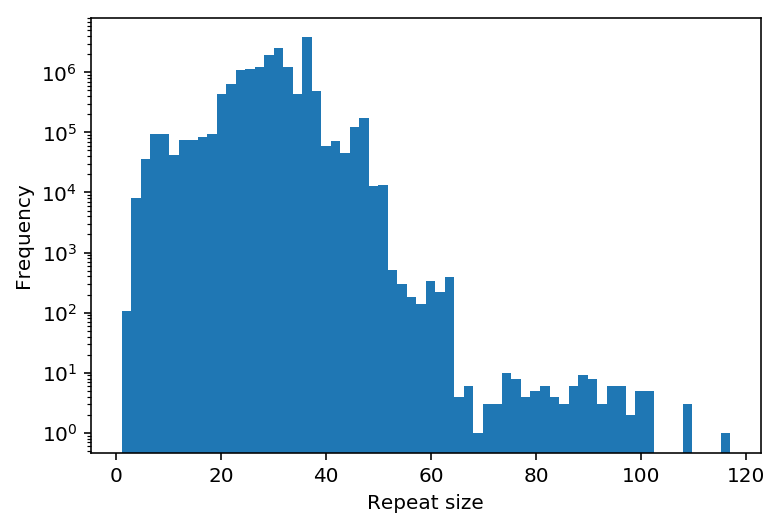

In [133]:
progbar = pyprind.ProgBar( 16001811, title='measuring repeat lengths...' )
repeat_sizes = zeros(16001811)
i = 0
with open ( 'data/all_repeats.fna' ) as f :
    for line in f.readlines() :
        if line.startswith('>') : continue
        progbar.update()
        repeat_sizes[i] = len(line) - 1
        i = i + 1

hist( repeat_sizes, 64 )
semilogy()
xlabel( 'Repeat size' )
ylabel( 'Frequency' )

In [95]:
# The original repeats fasta file doesn't have unique IDs for each repeat 
# within a given array.

import gzip

with gzip.open( 'data/all_repeats.fna.gz' ) as f1 :
    with open( 'data/repeats.fa', 'w' ) as f2 :
        i = 0
        this_header = ''
        while True :
            header   = f1.readline().decode('utf-8')
            sequence = f1.readline().decode('utf-8')
            if header == '' : break
            if header != this_header :
                this_header = header
                i = 0
            f2.write( header.strip() + '__' + str(i) + '\n' + sequence )
            i = i + 1

In [96]:
# find unique repeat sequences

from screed import make_db, ScreedDB
import pyprind

#make_db( 'data/repeats.fa' )
repeats = ScreedDB( 'data/repeats.fa')

unique_repeats = {}
progbar = pyprind.ProgBar( len(repeats), 'finding unique repeats...' )
for item in repeats.itervalues() :
    progbar.update()
    seq = str(item.sequence)
    if not seq in unique_repeats :
        unique_repeats[ seq ] = []
    unique_repeats[ seq ].append( item.name )

with open( 'data/unique_repeats.fa', 'w' ) as f :
    for seq,name in unique_repeats.items() :
        f.write( '> ' + name[0] + '\n' + seq.replace('-','') + '\n' )

print( 'total repeats  : ', len( repeats ) )
print( 'unique repeats : ', len( unique_repeats ) )

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:16:20


total repeats  :  16001811
unique repeats :  3854456


In [97]:
sorted_unique_repeats = sorted( unique_repeats.items(), key=lambda x : len(x[1]), reverse=True )

Text(0, 0.5, 'Frequency')

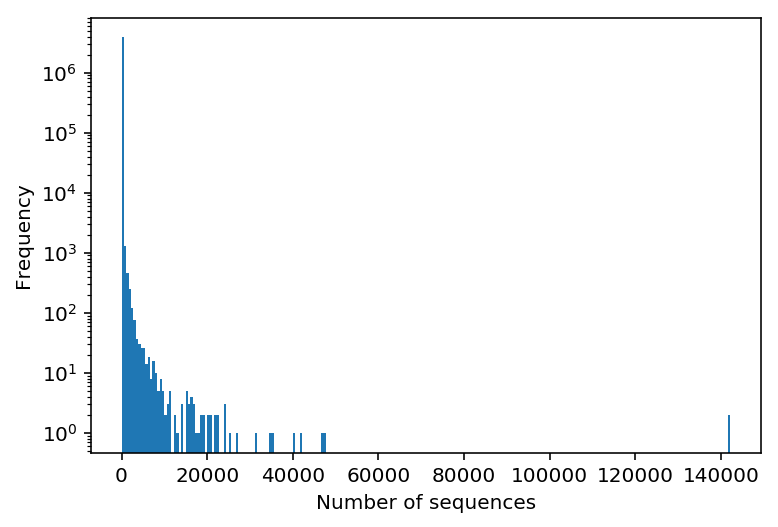

In [98]:
result = hist( [ len(i[1]) for i in sorted_unique_repeats ], 256 )
semilogy()
xlabel( 'Number of sequences' )
ylabel( 'Frequency' )

In [57]:
isolate_oids = set( open( 'data/taxonOids.public.txt' ).read().split() )
isolate_repeats = {}

progbar = pyprind.ProgBar( len(sorted_unique_repeats), title='Removing metagenome records...' )

for seq, repeat_ids in sorted_unique_repeats :
    progbar.update()
    isolate_repeats[ seq ] = set( x.split('__')[0] for x in repeat_ids ) & isolate_oids

Removing metagenome records...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:21


[]

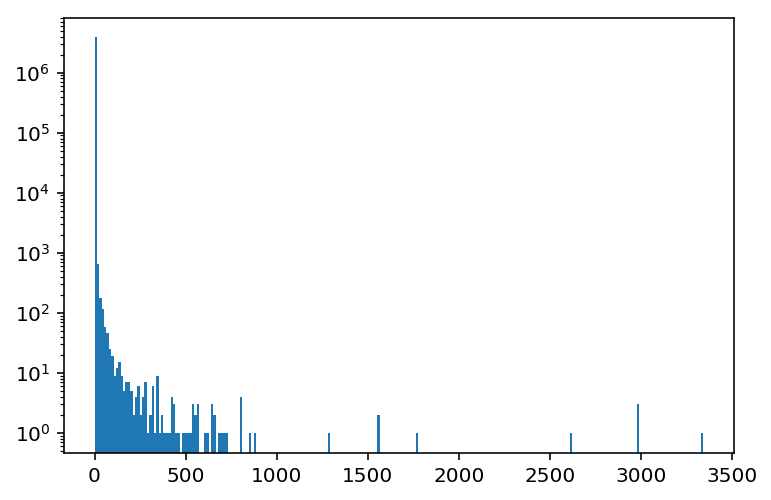

In [62]:
result = hist( [ len(i[1]) for i in isolate_repeats.items() ], 256 )
semilogy()
#list(isolate_repeats.items())[0]

In [64]:
with open( 'data/isolate_repeat_types.csv', 'w' ) as f :
    f.write( ','.join( [ 'taxon_oid', 'repeat_group' ] ) + '\n' )
    for n,(seq,taxa) in enumerate( isolate_repeats.items() ) :
        for taxon in taxa :
            f.write( ','.join( [ taxon, str(n) ] ) + '\n' )

In [36]:
with open( 'data/unique_repeats.fa', 'w' ) as f :
    for seq,name in unique_repeats.items() :
        if seq.__contains__( '-' ) : continue
        if seq.__contains__( '[' ) : continue
        f.write( '> ' + name + '\n' + seq + '\n' )

In [34]:
!vsearch --cluster_fast data/unique_repeats.fa \
--id 0.70 --strand both \
--minseqlength 8 \
--clusters data/repeat_clusters/cluster \
--consout  data/repeat_clusters/consensus.fa \
--msaout   data/repeat_clusters/msa.fa

vsearch v2.10.4_linux_x86_64, 15.5GB RAM, 4 cores
https://github.com/torognes/vsearch

Reading file data/unique_repeats.fa 100%                                        
109431209 nt in 3839985 seqs, min 8, max 117, avg 28
minseqlength 8: 14471 sequences discarded.
Masking 100%                                                                                                  
Sorting by length 100%
Counting k-mers 100%                                        
Clustering 100%                                                                                                                                                                                                                                                                                                                                                                                                                
Sorting clusters 100%
Writing clusters 100%                                                                                  

In [38]:
!lastdb -P 4 -cR01 -v -p repeatdb data/unique_repeats.fa
!lastal -P 4 -v -f BlastTab+ data/repeatdb data/unique_repeats.fa > data/repeats_all_v_all.tsv

lastdb: reading data/unique_repeats.fa...
lastdb: masking...
lastdb: writing...
lastdb: gathering...
lastdb: sorting...
lastdb: bucketing...
lastdb: writing...
lastdb: done!
lastal: batch size=8388608
lastal: calculating matrix probabilities...
lastal: matrix lambda=0.324032
lastal: matrix letter frequencies (upper=reference, lower=query):
A   C   D   E   F   G   H   I   K   L   M   N   P   Q   R   S   T   V   W   Y  
7.8 2.4 5.4 4.7 5.6 7   2.5 6.7 5   8.9 3.1 3.9 4.9 4.3 6.8 5.3 5.4 5.9 1.4 3  
7.8 2.4 5.4 4.7 5.6 7   2.5 6.7 5   8.9 3.1 3.9 4.9 4.3 6.8 5.3 5.4 5.9 1.4 3  
lastal: getting E-value parameters...
0.30593548727296388, 0.10240374069870158,
0.99050553069382763, -6.5543626660042129,
0.99050553069382763, -6.5543626660042129,
9.286796977904153, -130.81685466300709,
9.286796977904153, -130.81685466300709,
9.2266144189146271, -129.25210812927941
lastal: reading data/repeatdb...
lastal: reading data/unique_repeats.fa...


In [36]:
df = pandas.read_csv( 'data/repeats_all_v_all.tsv', sep='\t', header=None, comment='#' )
df.columns = [ field.strip() for field in open( 'data/repeats_all_v_all.tsv' ).readlines()[35][10:].split(',') ] + ['raw score']
df = df.where( df['subject id'] != df['query id'] ).dropna() # drop self-alignments
df.head()

,query id,subject id,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,evalue,bit score,query length,subject length,raw score
1,637000031__NC_004307__1__3,2503754032__UCD306_DRAFT_BLL306_UCD306_longum_...,95.65,23.0,1.0,0.0,1.0,23.0,1.0,23.0,2.000000e-12,59.3,23.0,23.0,127.0
2,637000031__NC_004307__1__3,637000031__NC_004307__3__1,100.00,20.0,0.0,0.0,3.0,22.0,1.0,20.0,2.600000e-11,56.3,23.0,20.0,120.0
3,637000031__NC_004307__1__3,637000031__NC_004307__3__2,95.00,20.0,1.0,0.0,3.0,22.0,1.0,20.0,2.300000e-10,53.6,23.0,20.0,114.0
5,637000031__NC_004307__2__0,3300007524__Ga0105481_1104169__1__0,100.00,19.0,0.0,0.0,1.0,19.0,1.0,19.0,4.900000e-10,52.3,20.0,20.0,111.0
6,637000031__NC_004307__2__0,649633017__NC_015052__1__3,100.00,19.0,0.0,0.0,1.0,19.0,4.0,22.0,4.900000e-10,52.3,20.0,23.0,111.0


In [45]:
G = networkx.from_pandas_edgelist( df, 'query id', 'subject id', ['bit score'] )
print( 'graph size       : ', len( G ) )
components = sorted( networkx.connected_component_subgraphs(G), key=len, reverse=True )
print( 'graph components : ', len( components ) )

graph size       :  66100
graph components :  19126


(array([47., 15., 11.,  5.,  3.,  2.,  4.,  1.,  1.,  0.,  3.,  1.,  0.,
         1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  29.      ,   49.765625,   70.53125 ,   91.296875,  112.0625  ,
         132.828125,  153.59375 ,  174.359375,  195.125   ,  215.890625,
         236.65625 ,  257.421875,  278.1875  ,  298.953125,  319.71875 ,
         340.484375,  361.25    ,  382.015625,  402.78125 ,  423.546875,
         444.3125  ,  465.078125,  485.84375 ,  506.609375,  527.375   ,
         548.140625,  568.90625 ,  589.671875,  610.4375  ,  631.203125,
         651.96875 ,  672.734375,  693.5     ,  714.265625,  735.03125 ,
         755.796875,  776.5625  ,  797.328125,  818.09375 ,  838.859375,
         859.625   ,  880.390625,  901.15625 ,  921.92

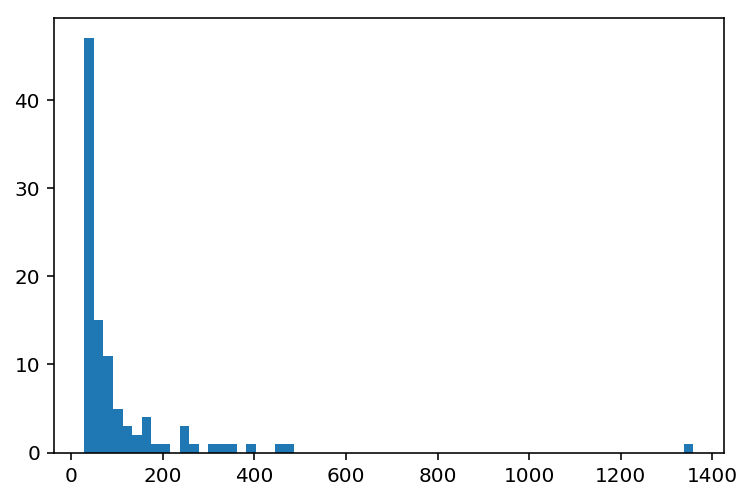

In [64]:
hist( [ len(g) for g in components[:100] ], 64 )

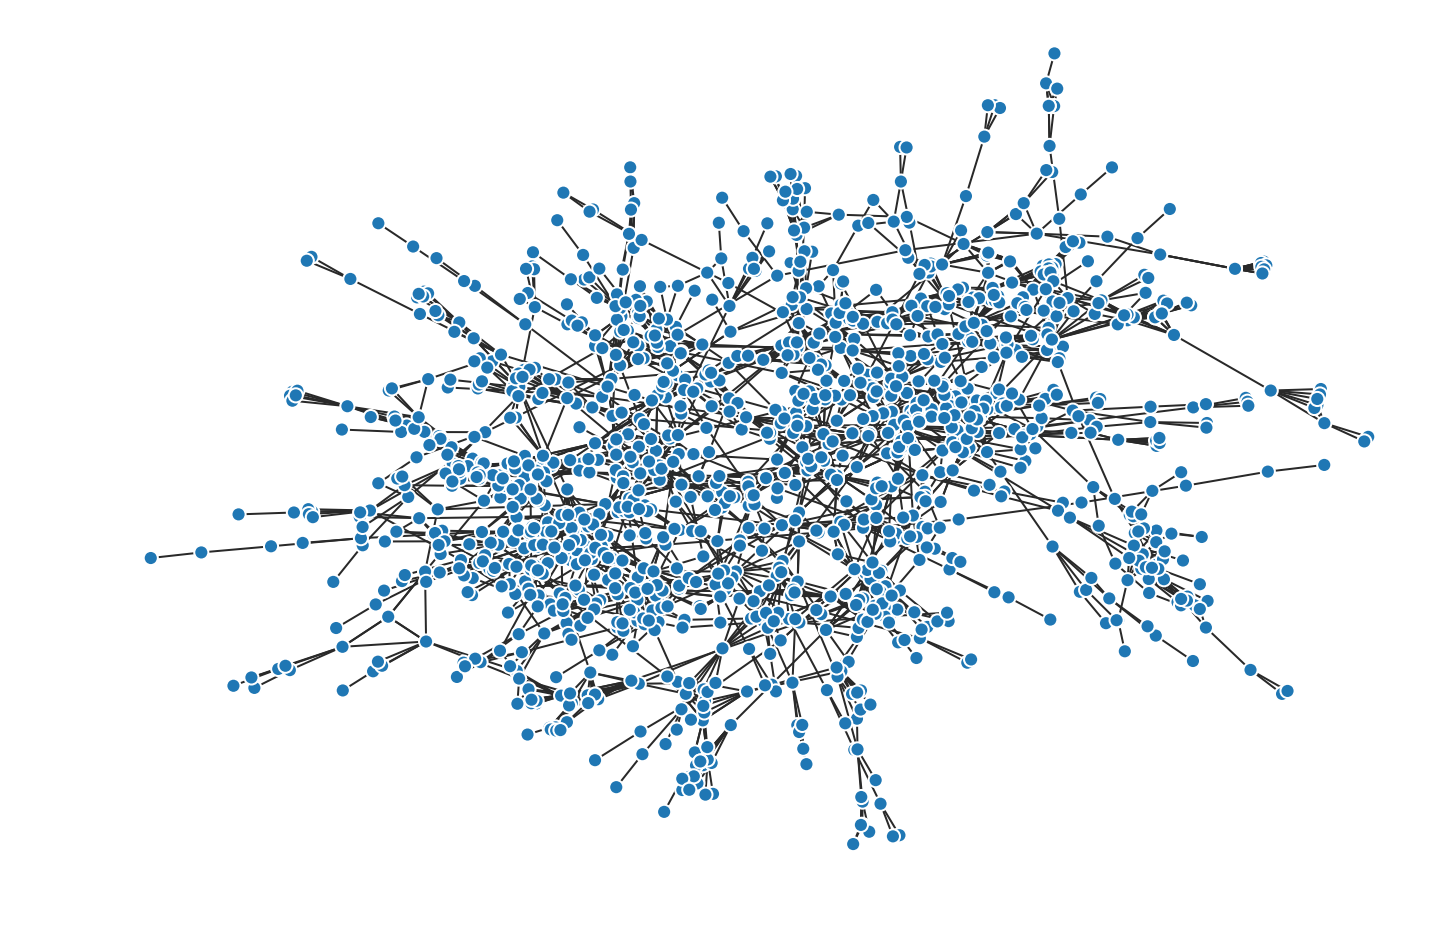

In [65]:
# Code cell for plotting an individual network

from grave import plot_network, use_attributes

figure( figsize = ( 12, 8 ) )

#def edge_style(edge_attrs):
#
#    alpha = edge_attrs['weight'] / 1000
#    return {'color' : 'black', 'alpha' : alpha }

def edge_style( edge_attributes ):
    return { 'linewidth' : edge_attributes.get( 'bitscore', 1 ) }

g = components[ 0 ]
    
centrality = networkx.closeness_centrality( g )
max_centrality = max( centrality.values() )
    
#for node, node_attributes in g.nodes.data():
#    node_attributes['size'] = ( ( max_centrality / centrality[node] ) + .1 ) * 30
#    if node_attributes['type'] == 'CRISPR_array' :
#        node_attributes['shape'] = 's'

#for u, v, edge_attributes in g.edges.data():
#    color_idx = ( 0.75 * edge_attributes['bitscore'] / bit_med )
#    cmap = get_cmap()
#    edge_attributes['color'] = cmap(color_idx)
#    edge_attributes['width'] = 2
    
    #grave.plot_network( g, layout='spring', edge_style=edge_style )
plot_network( g, layout='spring',
              node_style=use_attributes(),
              edge_style=use_attributes('color') )

In [5]:
metadata = pandas.read_csv( 'data/Table1_5_combined.txt', sep='\t', 
                      dtype={'Body_site':str, 'POGs_SUBFAMILY':str} )
metadata.head()

,UViG,TAXON_OID,Scaffold_ID,VIRAL_CLUSTERS,Ecosystem,Ecosystem_Category,Ecosystem_Type,Ecosystem_Subtype,Habitat,Body_site,...,Host,Host_detection,Host_domain,Estimated_completeness,Quality,POGs_ORDER,POGs_FAMILY,POGs_SUBFAMILY,POGs_GENUS,putative_retrovirus
0,2003000007_____2003296998,2003000007,2003296998,sg_24096,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
1,2003000007_____2003297061,2003000007,2003297061,sg_24097,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
2,2003000007_____2003297087,2003000007,2003297087,sg_24098,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
3,2003000007_____2003297164,2003000007,2003297164,sg_24099,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,Bacteria,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN
4,2003000007_____2003297262,2003000007,2003297262,sg_24100,Environmental,Air,Outdoor Air,0,Air,NaN,...,NaN,NaN,NaN,NaN,Genome_fragment,NaN,NaN,NaN,NaN,NaN


In [6]:
# Basic statistics for spacers

import gzip

n_meta_spacers = str( gzip.open( 'data/meta_spacers.fna.gz' ).read() ).count( '>' )
n_iso_spacers  = open( 'data/viral_spacers.fna' ).read().count( '>' )

print( 'all spacers        : {}'.format( n_iso_spacers + n_iso_spacers ) )

print( 'isolate spacers    : {} ({:2.2f}%)'.format( n_iso_spacers,
                                                 100 * n_iso_spacers / ( n_iso_spacers + n_meta_spacers ) ) )

print( 'metagenome spacers : {} ({:2.2f}%)'.format( n_meta_spacers,
                                                 100 * n_meta_spacers / ( n_iso_spacers + n_meta_spacers ) ) )


print( '--------------------------------------')

isolate_oids = set( int(i) for i in open( 'data/taxonOids.public.txt' ).read().split() )
#set(metadata['TAXON_OID']) & set(isolate_oids)
print( 'hits to UViGs      :', metadata.shape[0] )

n_isolate_hits = len( set( metadata['TAXON_OID'] ) ^ isolate_oids )

print( 'isolate hits       : {} ({:2.2f}%)'.format( n_isolate_hits,
                                                  100 * n_isolate_hits / metadata.shape[0] ) )

n_meta_hits = metadata.shape[0] - n_isolate_hits
print( 'metagenome hits    : {} ({:2.2f}%)'.format( n_meta_hits,
                                                  100 * n_meta_hits / metadata.shape[0] ) )

all spacers        : 2437200
isolate spacers    : 1218600 (4.34%)
metagenome spacers : 26852016 (95.66%)
--------------------------------------
hits to UViGs      : 746045
isolate hits       : 90961 (12.19%)
metagenome hits    : 655084 (87.81%)


In [10]:
v2h_taxonomy = pandas.read_csv( 'data/predicted_hosts.tsv', sep='\t' )

df['host_img_oid'] = [ int(i.split(':')[0]) for i in df['CRISPR_array'] ]

df = df.merge( v2h_taxonomy, left_on='host_img_oid', right_on='Host_Taxon_ID' )

/home/russell/opt/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


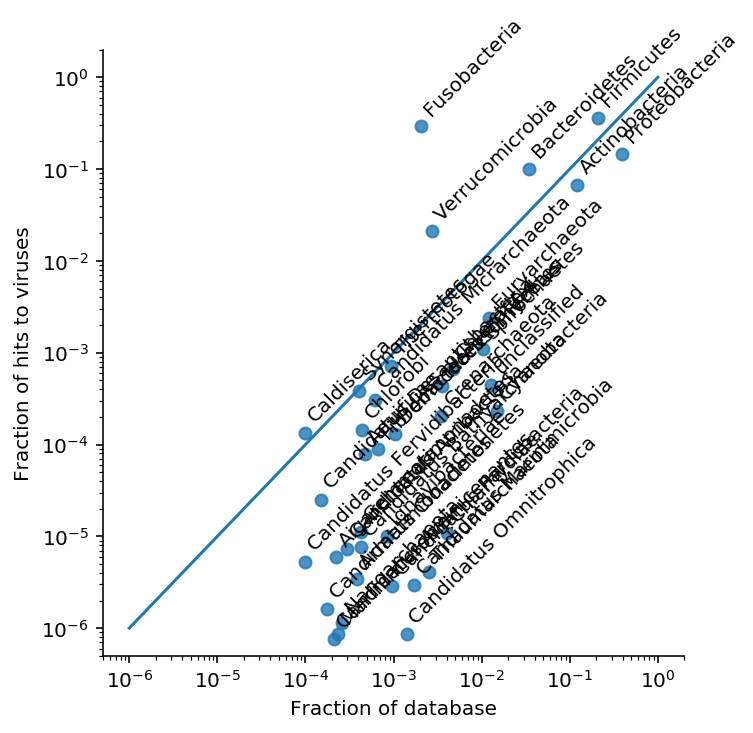

In [94]:
taxon_level = list(df['Host_Phylum'])
iso_phyla = list( pandas.read_csv( 'data/all_public.txt', sep='\t' )['phylum'] )

viral_hits_by_phyla = {}
n_isolates_by_phyla = {}
for category in set( taxon_level ) :
    viral_hits_by_phyla[ category ] = taxon_level.count( category )
    n_isolates_by_phyla[ category ] = iso_phyla.count( category )

phyla_hits_table = []
for phylum,n in sorted( viral_hits_by_phyla.items(), key=lambda x : x[1], reverse=True ) :
    phyla_hits_table.append( {'phylum'          : phylum,
                              'n_viral_hits'    : n,
                              'frac_viral_hits' : n / len(taxon_level),
                              'n_db_records'    : n_isolates_by_phyla[ phylum ],
                              'frac_db_records' : n_isolates_by_phyla[ phylum ] / len(iso_phyla) } )
    #print( '{} : {}, {}, {:2.2f}%'.format( p, hits, db_records, hits * 100 / db_records ))
    #print( '{} {} {:2.2f}%'.format( category, n, n * 100 / len(taxon_level) ) )

phyla_hits_table = pandas.DataFrame( phyla_hits_table )

p1 = seaborn.lmplot( x = 'frac_db_records',
                     y = 'frac_viral_hits',
                     data = phyla_hits_table,
                     fit_reg = False,
                     aspect = 1, size = 5 )

p1.ax.set_xscale( 'log' )
p1.ax.set_yscale( 'log' )

xlabel( 'Fraction of database' )
ylabel( 'Fraction of hits to viruses' )

plot( [10**-6, 1], [10**-6, 1] )

for line in range( 0, phyla_hits_table.shape[0] ):
     p1.ax.annotate( phyla_hits_table.phylum[line],
                     ( phyla_hits_table.frac_db_records[line],
                       phyla_hits_table.frac_viral_hits[line] ),
                     xytext=(5,5), textcoords="offset points",
                     rotation=45, rotation_mode='anchor' )

In [125]:
pht = phyla_hits_table.sort_values( 'frac_db_records', ascending=False )
pht

,frac_db_records,frac_viral_hits,n_db_records,n_viral_hits,phylum
2,0.390174,1.472033e-01,31354,1551404,Proteobacteria
0,0.208676,3.612226e-01,16769,3806994,Firmicutes
4,0.120522,6.769875e-02,9685,713490,Actinobacteria
3,0.034259,1.008216e-01,2753,1062578,Bacteroidetes
14,0.014759,2.316117e-04,1186,2441,Cyanobacteria
10,0.012705,4.487062e-04,1021,4729,unclassified
6,0.012133,2.372099e-03,975,25000,Euryarchaeota
7,0.010304,1.084618e-03,828,11431,Spirochaetes
41,0.005326,1.897679e-07,428,2,Tenericutes
9,0.004679,6.654212e-04,376,7013,Chloroflexi


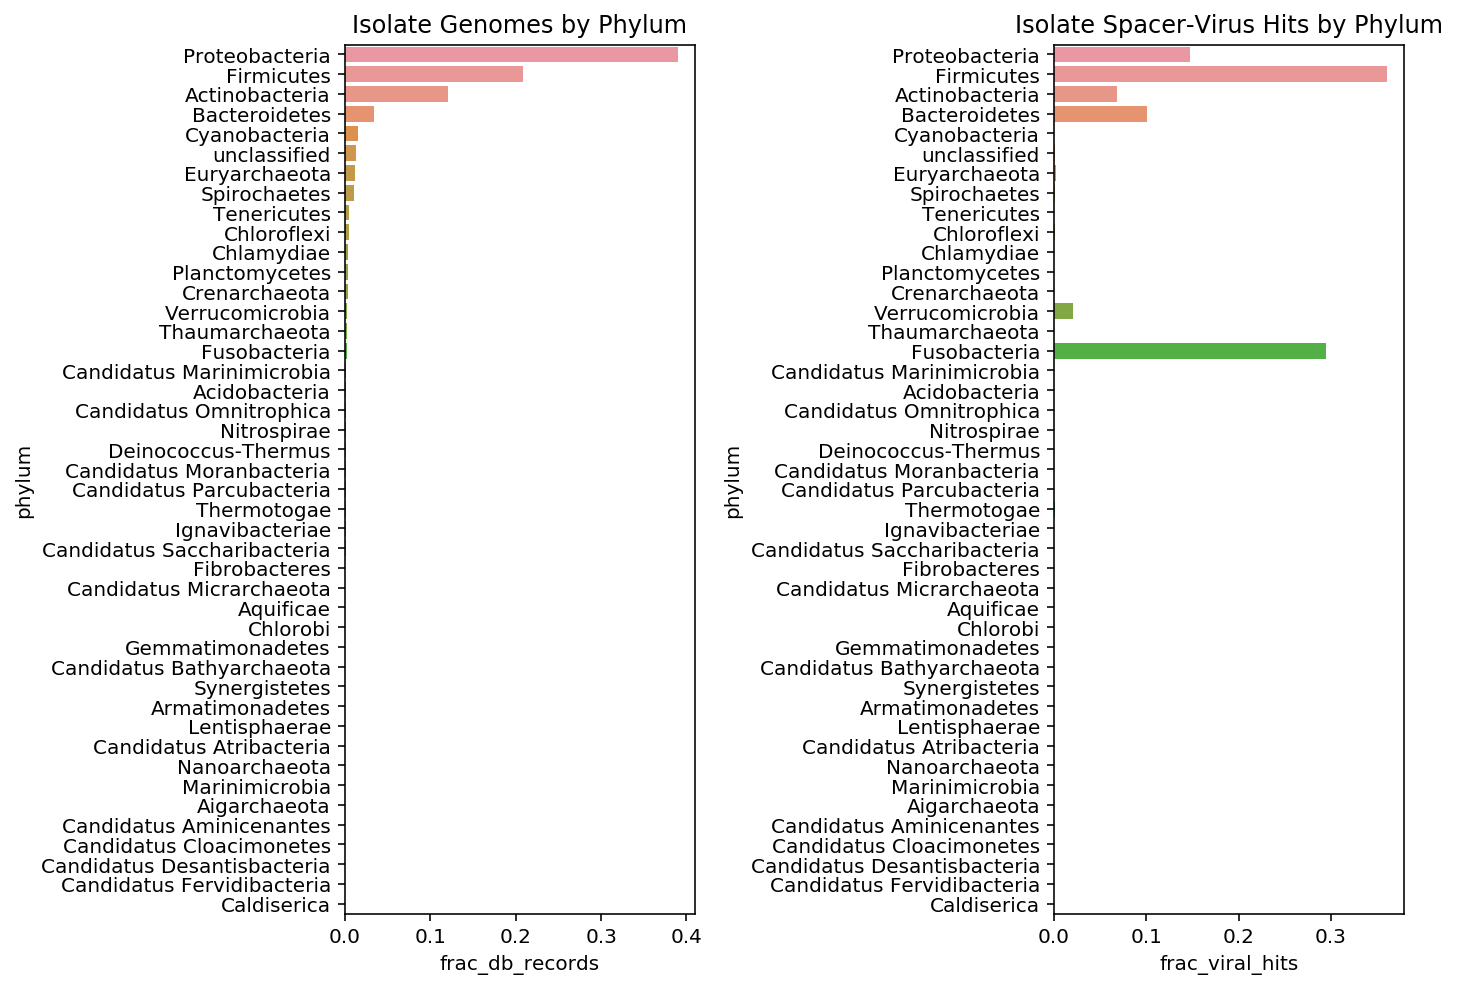

In [126]:
figure( figsize=( 10, 7 ) )

subplot( 1, 2, 1 )

seaborn.barplot( x='frac_db_records', y='phylum', data=pht )
title( 'Isolate Genomes by Phylum' )

subplot( 1, 2, 2 )

seaborn.barplot( x='frac_viral_hits', y='phylum', data=pht )
title( 'Isolate Spacer-Virus Hits by Phylum' )

tight_layout()

### Construct isolate spacer and virus network

In [3]:
metadata.columns

Index(['UViG', 'TAXON_OID', 'Scaffold_ID', 'VIRAL_CLUSTERS', 'Ecosystem',
       'Ecosystem_Category', 'Ecosystem_Type', 'Ecosystem_Subtype', 'Habitat',
       'Body_site', 'perc_VPF', 'Host', 'Host_detection', 'Host_domain',
       'Estimated_completeness', 'Quality', 'POGs_ORDER', 'POGs_FAMILY',
       'POGs_SUBFAMILY', 'POGs_GENUS', 'putative_retrovirus'],
      dtype='object')

The `BlastTab+` output format for LAST has the following fields, delimited by tabs :

0. query id
* subject id
* % identity
* alignment length
* mismatches
* gap opens
* q. start
* q. end
* s. start
* s. end
* evalue
* bit score
* query length
* subject length
* raw score


query_id : 637000024:NC_003228:2:2998261
taxon_id:scaffold_id:annotation_in_scaffold:scaffold_coordinate

subject_id : 7000000526_____SRS019397_WUGC_scaffold_4145
taxon_id_____scaffold_id

In [8]:
lastal_cols = [ 'query_id', 'subject_id', 'identity', 'alignment_length',
                'mismatches', 'gap_opens', 'q_start', 'q_end', 's_start',
                's_end', 'evalue', 'bitscore', 'query_length', 'subject_length',
                'raw_score' ]

df = pandas.read_csv( 'data/spacers_vs_all_viral_sequences_combined_v2_Filtered_1Snp_100AF.lout', 
                      sep='\t', names=lastal_cols, index_col=False )

# merge viral clusters
clusters = metadata[ ['UViG', 'VIRAL_CLUSTERS'] ]
clusters.columns = [ 'subject_id', 'vcluster' ]
df = df.merge( clusters, on='subject_id' )

# merge CRISPR array
df['CRISPR_array'] = [ ':'.join(name.split(':')[:2]) for name in df.query_id ]

print(df.shape)
df.head()

(90108, 17)


,query_id,subject_id,identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue,bitscore,query_length,subject_length,raw_score,vcluster,CRISPR_array
0,637000024:NC_003228:2:2998261,7000000526_____SRS019397_WUGC_scaffold_4145,100.00,34,0,0,34,1,22441,22474,1.400000e-08,55.3,34,47940,34,sg_282454,637000024:NC_003228
1,637000024:NC_003228:2:2998455,7000000526_____SRS019397_WUGC_scaffold_4145,97.06,34,1,0,1,34,22655,22688,2.500000e-07,52.2,34,47940,32,sg_282454,637000024:NC_003228
2,647533110:NZ_GG705213:1:413342,7000000526_____SRS019397_WUGC_scaffold_4145,96.67,30,1,0,30,1,34447,34476,3.200000e-05,45.9,30,47940,28,sg_282454,647533110:NZ_GG705213
3,650377910:FQ312004:2:4712990,7000000526_____SRS019397_WUGC_scaffold_4145,100.00,30,0,0,1,30,29564,29593,1.800000e-06,49.0,30,47940,30,sg_282454,650377910:FQ312004
4,2571042234:JGEV01000024:2:689262,7000000526_____SRS019397_WUGC_scaffold_4145,100.00,34,0,0,34,1,22441,22474,1.400000e-08,55.3,34,47940,34,sg_282454,2571042234:JGEV01000024


In [9]:
print( 'viral clusters :', len(set(df.vcluster)) )
print( 'UViGs          :', len(set(metadata.UViG)))

viral clusters : 12253
UViGs          : 746045


In [6]:
#G = networkx.Graph()
#G.add_nodes_from( set( df['query_id'] ) | set( df['subject_id'] ) )
G = networkx.convert_matrix.from_pandas_edgelist( df, 'CRISPR_array', 'vcluster', 'bitscore' )

#G.add_nodes_from( set( ':'.join(name.split(':')[:2]) for name in df.query_id ) )
#G.add_nodes_from( set( df.subject_id ) )

networkx.set_node_attributes( G, { ':'.join(name.split(':')[:2]) : {'type':'CRISPR_array'} for name in df.query_id } )
networkx.set_node_attributes( G, { name : {'type':'vcluster'} for name in df.vcluster } )

#progbar = pyprind.ProgBar( df.shape[0], title='adding graph edges...' )

#for n,row in df.iterrows() :
#    progbar.update()
#    G.add_edge( row['subject_id'], row['query_id'], weight=row['bitscore'] )

In [7]:
# get the adjacency matrix in sparse form
#aj = networkx.to_scipy_sparse_matrix(G)

# decompose graph into connected component subgraphs
components = sorted( networkx.connected_component_subgraphs(G), key=len, reverse=True )

## Part 2 : Basic statistics on CRISPR arrays, repeats & viruses

* Spacers: xxx
    * From Isolates: xxx
    * From Metagenomes: xxx
* Arrays: xxx
    * From Isolates: xxx
    * From Metagenomes: xxx
        * Arrays from metagenomes with Taxonomic info
        * Spacers from arrays with Taxonomic info
* Viruses: xxx
    * Isolates: xxx
    * Prophages: xxx
    * Metagenomes (mVGs): xxx

* The above data have been generated from:
    * Isolate Genomes: xxx
    * Metagenomes: xxx


Connected components :  1261


[]

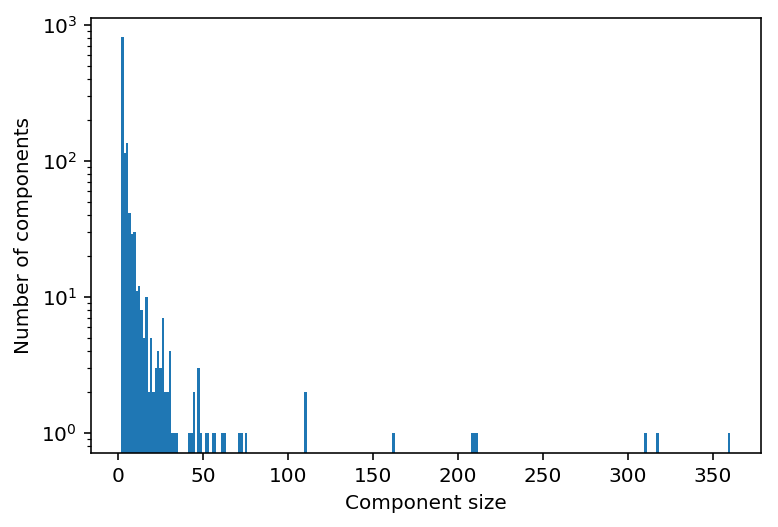

In [28]:
print( 'Connected components : ', len(components) )
hist( list( map( len, components[1:] ) ), 256 )
xlabel( 'Component size' )
ylabel( 'Number of components' )
semilogy()

### Spacer clustering

* Total number of spacers: xxx

* Number of spacer clusters: xxx (clustering at 100% or 99% identity, and 100% of the shortest spacer alignment)
    * clusters of 2 or more spacers: xxx
    * Singleton spacers: xxx

Plot : Distribution of spacer cluster size



### CRISPR repeat statistics and clustering

* Total number of repeats: xxx

* Number of repeat clusters (RC): xxx
    * clusters of 2 or more repeats: xxx
    * Singleton repeats: xxx

Plot 1: Distribution of repeat cluster size

Plot 2: Taxonomic distribution of repeats per cluster at species, Genus, family, class, order, and phylum levels
Take repeats from the crispr arrays only from isolate genomes, and metagenome contigs with taxonomic info. For the RC of these, identify how many repeats have uniform taxonomy at species, genus or family level.
Eg 50% at species level would mean that in 50% of the RCs, the repeats are coming from genomes/contigs of the same species. 80% at family level would mean that in 80% of the RCs the repeats within a cluster are all from the same family, etc. 



## Do repeats have phylogenetic signal?

Working from [José Hidasi Neto's notes](http://rfunctions.blogspot.ch/2014/02/measuring-phylogenetic-signal-in-r.html), which are themselves a summary of [*How to measure and test phylogenetic signal*](http://www.will.chez-alice.fr/pdf/Munkemuller2012MEE.pdf) by Münkemüller et al., we can calculate and test four measures of phylogenetic signal : Bloomberg's K, Moran's I, Abouheif's Cmean and Pagel's λ. Summary of interpreatation here:

http://blog.phytools.org/2012/03/phylogenetic-signal-with-k-and.html

Lee -- You can use [this old notebook](https://github.com/ryneches/fishpoo/blob/master/notebooks/fishpoo_1.ipynb) of mine as a guide. The relevant bits start at code cell 59.

**[ ] Action item (Russell) :** Find or build a tree of all isolate genomes from which we have CRISPR arrays 

**[ ] Action item (Lee) :** Cluster repeat sequences

**[ ] Action item (Lee) :** Construct a character matrix on repeat clusters 

**[ ] Action item (Lee) :** Test repeat cluster trait for phylogenetic signal

**[ ] Action item (Russell) :** Build a phylogenetic tree of repeats, use `SuchTree` to test against species tree for phylogenetic informativeness 


## Part 3 : Networks

Graph 1: size (bp) distribution of spacers

Graph 2: Distribution of spacers within arrays
Occurrence of arrays with 2, 3, n spacers 

<table>
    <tr>
        <td>
            <img src="figures/viral_net_diagram_1.png" alt="Diagram 1" width="400"/>
            Level 1 Viral connection (L1C): Virus 1 (V1) is in the same array with Virus 2 (V2) 
        </td>
        <td>
            <img src="figures/viral_net_diagram_2.png" alt="Diagram 2" width="400"/> 
            Level 2 Viral connection (L2C): Virus 1 (V1) is in the same array with Virus 2 (V2),
            and in a different array with Virus 3 (V3). Then V2 and V3 are also connected (through V1).
        </td>
    </tr>
    <tr>
        <td> 
            <img src="figures/viral_net_diagram_3.png" alt="Diagram 3" width="400"/>
            Level 3 Viral connection (L3C): V1 is in the same array with V2, and V4 is in the same 
            array with V3. If V1 and V4 are part of the same Viral Cluster (vOTU), then V2 and V3
            have Level 3 connectivity
        </td>
        <td> 
            <img src="figures/viral_net_diagram_4.png" alt="Diagram 4" width="400"/>
            Level 4 Viral connection (L4C): V1 is in the same array with V2, and V4 is in the same
            array with V3. If V1 and V4 connect to two spacers that belong to the same spacer clusters
            then V1 and V4 have L4 connection, while V1 with V3, V4 with V2 and V2 with V3 have
            Level 5 connection.
        </td>
    </tr>
</table>

measuring spacer lengths...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Text(0, 0.5, 'Frequency')

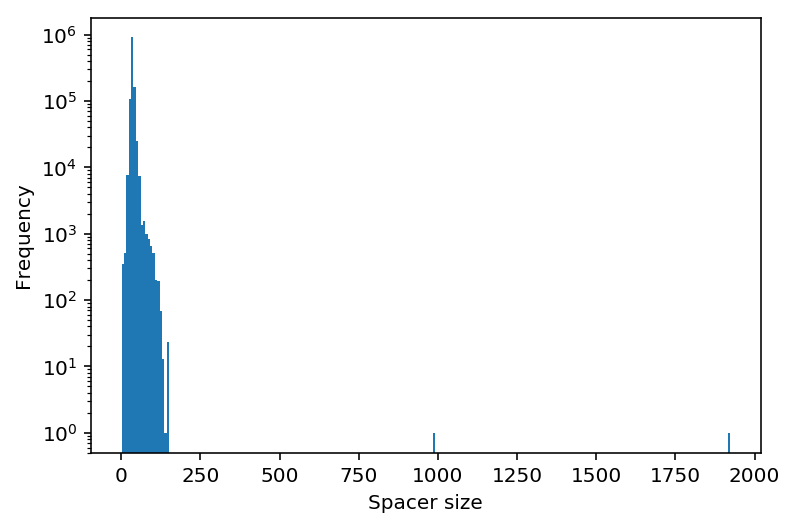

In [130]:
progbar = pyprind.ProgBar( 1218600, title='measuring spacer lengths...' )
spacer_sizes = zeros(1218600)
i = 0
with open ( 'data/viral_spacers.fna' ) as f :
    for line in f.readlines() :
        if line.startswith('>') : continue
        progbar.update()
        spacer_sizes[i] = len(line) - 1
        i = i + 1

hist( spacer_sizes, 256 )
semilogy()
xlabel( 'Spacer size' )
ylabel( 'Frequency' )

In [9]:
bit_min = min( df['bitscore'] )
bit_max = max( df['bitscore'] )
bit_med = median( df['bitscore'] )

pandas.DataFrame.describe( df['bitscore'] )

count    90108.000000
mean        52.270578
std          4.649566
min         42.700000
25%         49.000000
50%         52.200000
75%         55.300000
max        155.000000
Name: bitscore, dtype: float64

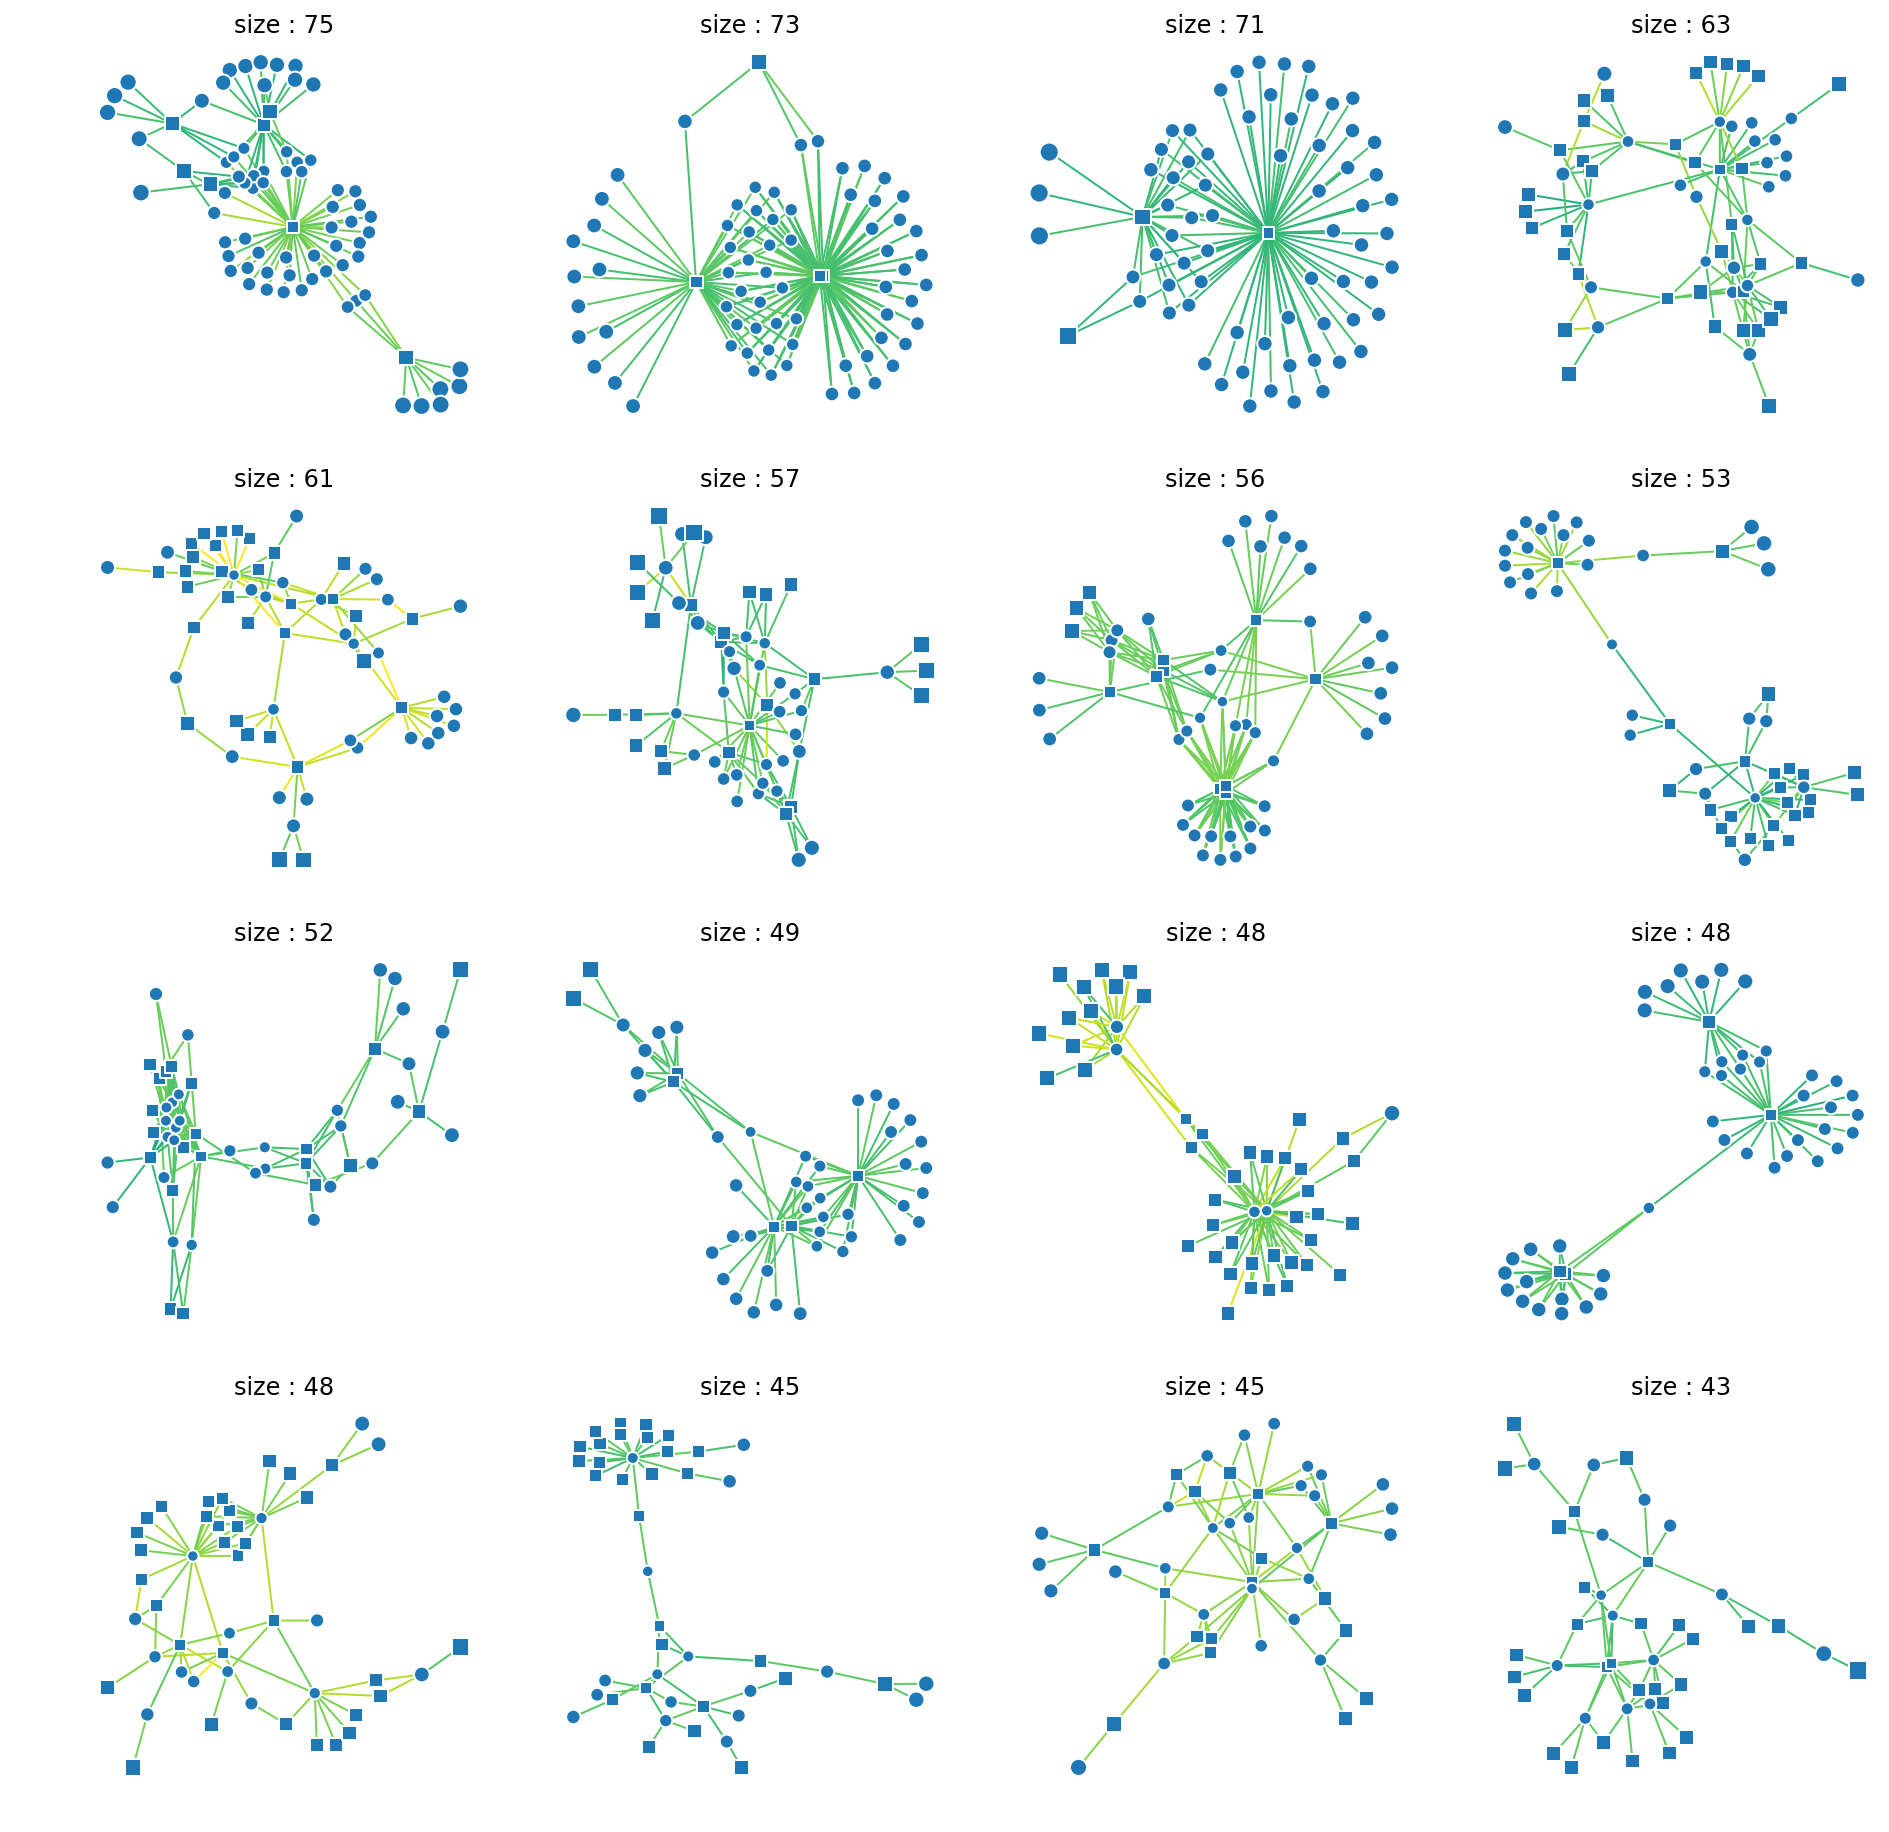

In [10]:
from grave import plot_network, use_attributes

figure( figsize = ( 16, 16 ) )

#def edge_style(edge_attrs):
#
#    alpha = edge_attrs['weight'] / 1000
#    return {'color' : 'black', 'alpha' : alpha }

def edge_style( edge_attributes ):
    return { 'linewidth' : edge_attributes.get( 'bitscore', 1 ) }

for n,g in enumerate(components[ 10:26 ]) :
    subplot( 4, 4, n+1 )
    title( ' : '.join( map( str, ('size', len(g) ) ) ) )
    
    centrality = networkx.closeness_centrality( g )
    max_centrality = max( centrality.values() )
    
    for node, node_attributes in g.nodes.data():
        node_attributes['size'] = ( ( max_centrality / centrality[node] ) + .1 ) * 30
        if node_attributes['type'] == 'CRISPR_array' :
            node_attributes['shape'] = 's'
    
    for u, v, edge_attributes in g.edges.data():
        #c = (centrality[u] +
        #     centrality[v]) / 2
        #color_idx = (c / max_centrality)
        color_idx = ( 0.75 * edge_attributes['bitscore'] / bit_med )
        cmap = get_cmap()
        edge_attributes['color'] = cmap(color_idx)
        edge_attributes['width'] = 2
    
    #grave.plot_network( g, layout='spring', edge_style=edge_style )
    plot_network( g, layout='spring',
                  node_style=use_attributes(),
                  edge_style=use_attributes('color') )

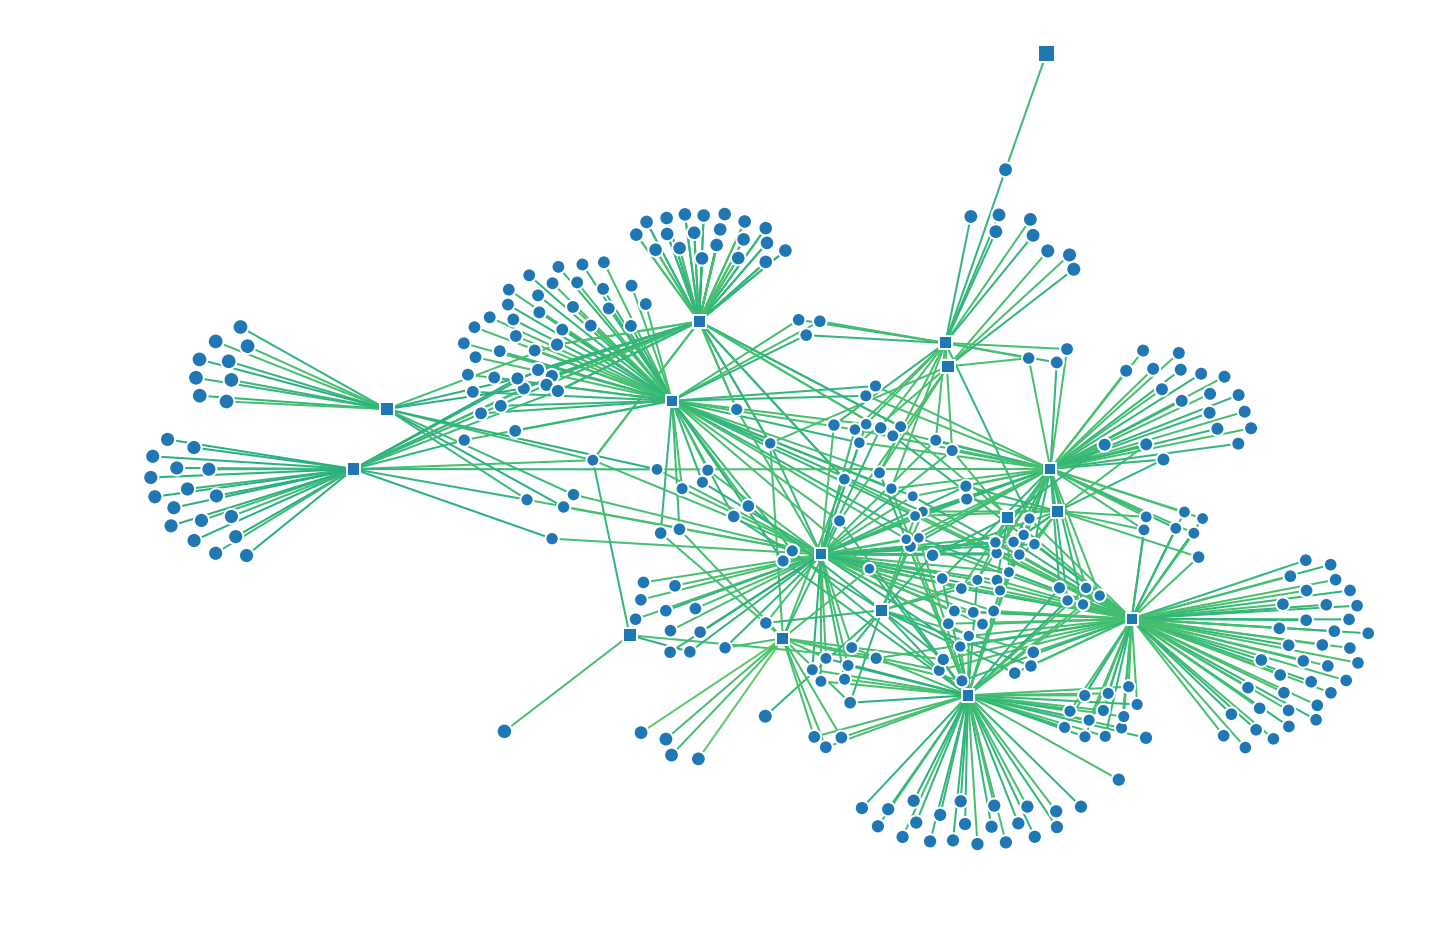

In [11]:
# Code cell for plotting an individual network

from grave import plot_network, use_attributes

figure( figsize = ( 12, 8 ) )

#def edge_style(edge_attrs):
#
#    alpha = edge_attrs['weight'] / 1000
#    return {'color' : 'black', 'alpha' : alpha }

def edge_style( edge_attributes ):
    return { 'linewidth' : edge_attributes.get( 'bitscore', 1 ) }

g = components[ 2 ]
    
centrality = networkx.closeness_centrality( g )
max_centrality = max( centrality.values() )
    
for node, node_attributes in g.nodes.data():
    node_attributes['size'] = ( ( max_centrality / centrality[node] ) + .1 ) * 30
    if node_attributes['type'] == 'CRISPR_array' :
        node_attributes['shape'] = 's'

for u, v, edge_attributes in g.edges.data():
    color_idx = ( 0.75 * edge_attributes['bitscore'] / bit_med )
    cmap = get_cmap()
    edge_attributes['color'] = cmap(color_idx)
    edge_attributes['width'] = 2
    
    #grave.plot_network( g, layout='spring', edge_style=edge_style )
plot_network( g, layout='spring',
              node_style=use_attributes(),
              edge_style=use_attributes('color') )

## Clustering coinfection networks by topology with graph tensor products

**[ ] Action item (Russell) :** Figure out why the WL kernel segfaults

**[ ] Action item (Russell) :** Perform hierarchical clustering of networks using WL and graphelt kernels as a distance metric

In [12]:
from graph_kernels import WL_subtree_kernel

kp = WL_subtree_kernel.compute_mle_wl_kernel( components, 3 )

ModuleNotFoundError: No module named 'graph_kernels'

In [16]:
import igraph
import graphkernels.kernels as gk

ig = igraph.Graph()
ig.add_vertices( list( set( df[ 'CRISPR_array' ] ) ) )
n = len(ig.vs)
ig.add_vertices( list( set( df[ 'vcluster' ] ) ) )
ig.vs[ 'label' ] = [ 0 ] * n + [ 1 ] * ( len(ig.vs) - n )
ig.add_edges( [ ( row.CRISPR_array, row.vcluster ) for n,row in df[ ['CRISPR_array',
                                                                     'vcluster' ] ].iterrows() ] )
ig.es[ 'weight' ] = list( df[ 'bitscore' ] )

igc = ig.components().subgraphs()

In [ ]:
#%%debug
#import pdb
#from pdb import set_trace as bp

kp = gk.CalculateWLKernel( igc[10:] )
#seaborn.clustermap( wlkp, mask=numpy.isnan(kp) )

#kp = gk.CalculateConnectedGraphletKernel( igc[1:162] )
#seaborn.clustermap( kp )

#kp = gk.CalculateExponentialRandomWalkKernel( igc[ 10: ] )

seaborn.clustermap( kp )

In [191]:
len(igc0.vs)

12983

## Ecology and biogeography of viruses and their hosts

In [13]:
import sqlite3
import os.path
from dna_features_viewer import GraphicFeature, GraphicRecord


NERSC_prefix = '/global/dna/projectdirs/microbial/img_web_data_merfs/'

def get_scaffold_stats( taxon, scaffold ) :
    scaffdb_path = os.path.join( NERSC_prefix, taxon, 'assembled', 'scaffold_stats.sdb' )
    if os.path.exists( scaffdb_path ) :
        conn = sqlite3.connect( scaffdb_path )
        scaff_df = pandas.read_sql_query( 'select * from scaffold_stats where scaffold_oid=:oid;', 
                                          conn, params={'oid':scaffold} )

        return scaff_df
    else :
        raise Exception( 'Could not find scaffold {} for taxon {}'.format( scaffold, taxon ) )

def get_crispr_stats( taxon, scaffold ) :
    scaffdb_path = os.path.join( NERSC_prefix, taxon, 'assembled', 'crispr.sdb' )
    if os.path.exists( scaffdb_path ) :
        conn = sqlite3.connect( scaffdb_path )
        scaff_df = pandas.read_sql_query( 'select * from taxon_crispr_details;', 
                                          conn, params={'oid':scaffold} )

        return scaff_df
    else :
        raise Exception( 'Could not find scaffold {} for taxon {}'.format( scaffold, taxon ) )
        
def get_scaffold_genes( taxon, scaffold ) :
    scaffdb_path = os.path.join( NERSC_prefix, taxon, 'assembled', 'scaffold_genes' )
    if os.path.exists( scaffdb_path ) :
        for dbfile in os.listdir( scaffdb_path ) :
            conn = sqlite3.connect( os.path.join( scaffdb_path, dbfile ) )
            
            scaff_df = pandas.read_sql_query( 'select * from scaffold_genes where scaffold_oid=:oid;', 
                                              conn, params={'oid':scaffold} )
            
            scaff_df['gene'] = [ '_____'.join( map( str, [ taxon, 
                                                           row.scaffold_oid,
                                                           row.gene_oid ] ) ) 
                                 for n,row in scaff_df.iterrows() ]
                        
            if scaff_df.shape[0] :
                return scaff_df    

The following code plots the location of all samples from which we have viral contigs.


**[ ] Action item (Russell) :** Some of these records appear to be broken, so some data-cleaning is required.

In [14]:
#taxon_table = pandas.read_csv( '../imgdb/img_taxon_table.csv', index_col=0 )
#env_table   = pandas.read_csv( '../imgdb/img_env_sample_table.csv', index_col=0 )
taxon_latlon = pandas.read_csv( '../imgdb/taxon_latlon.csv', index_col=0 )

taxon_latlon.dropna().head()

,TAXON_OID,LATITUDE,LONGITUDE,GOLD_ID,ANALYSIS_PROJECT_TYPE
5,637000271,58.42198,-149.574839,Gp0000347,Genome Analysis
10,2523533631,29.82,-95.34,Gp0000353,Genome Analysis
11,637000295,40.75,-73.98,Gp0000354,Genome Analysis
13,637000029,33.94,-117.4,Gp0000356,Genome Analysis
16,2524023073,35.080371,-106.627085,Gp0000166,Genome Analysis


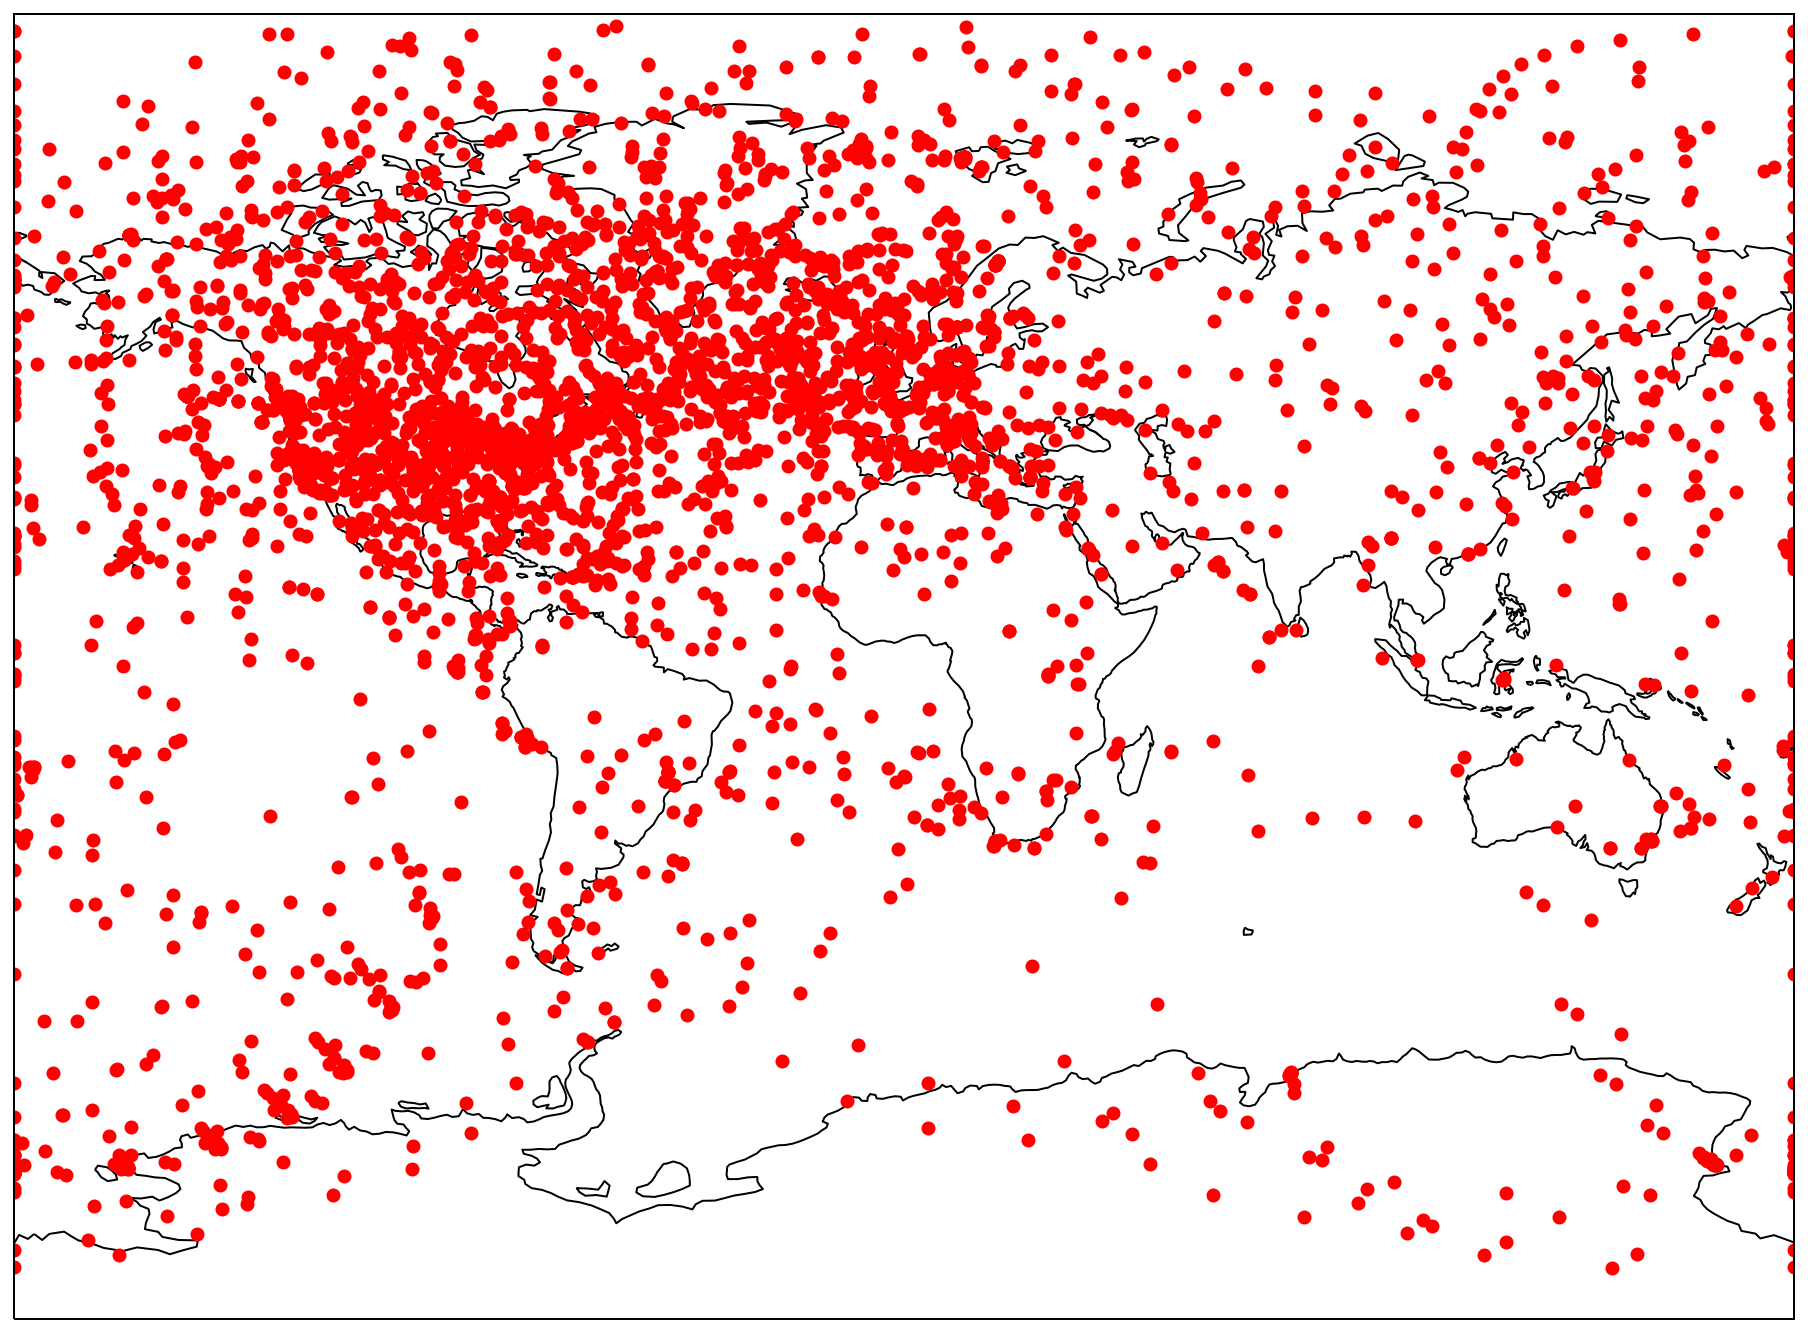

In [15]:
d = metadata.merge( taxon_latlon, on='TAXON_OID' )
locations = set()
for n,item in d[ ['LATITUDE', 'LONGITUDE'] ].dropna().iterrows() :
    locations.add( tuple( map( float, item ) ) )

figure( figsize=(18,12) )

ax = plt.axes( projection=cartopy.crs.Miller() )
#ax.add_image( GoogleTiles( style='satellite' ), 3 )
ax.coastlines()

y, x = zip(*locations)
plot( x, y, 'ro', transform=cartopy.crs.Geodetic() )